In [3]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

# Basic packages
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from astropy.io import fits
from scipy.io import readsav
from scipy.interpolate import interp1d
from astropy.io import ascii

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import corner
from scipy.stats import chisquare

# Chebyshev
from numpy.polynomial.chebyshev import Chebyshev



In [4]:
# convert wavelength to air (apply to APOGEE spectra)
def wavelength_vac_to_air(vacuum_wavelength):
    return(vacuum_wavelength / (1.0 +  0.05792105/(238.0185 - (0.0001/vacuum_wavelength)**2) + 0.00167917/( 57.362 - (0.0001/vacuum_wavelength)**2)))

In [5]:
# read in the line list 

from astropy.table import Table
linelist = Table.read('linelist.txt',format='ascii')


In [6]:
# observed spectra from APOGEE 
tmass_id = '00204121-7202433'

obs_spec = Table.read(tmass_id+'.fits') # this file already neglect the empty flux between the chips 
# convert the wavelength of the observed spectra from vacuum to air 
obs_spec['WAVE_VAC']=obs_spec['WAVE']
obs_spec['WAVE']=wavelength_vac_to_air(obs_spec['WAVE'])

# sme aspcap 
sme_a = readsav('sme_ir_'+tmass_id+'_aspcap.out').result[0]

O_01 = readsav('sme_ir_'+tmass_id+'_aspcap_O_0.1.out').result[0]

Ti_01 = readsav('sme_ir_'+tmass_id+'_aspcap_Ti_0.1.out').result[0]

LET_a = readsav('sme_ir_'+tmass_id+'_aspcap_LTE.out').result[0]

uncali_a = readsav('sme_ir_'+tmass_id+'_uncalibrated.out').result[0]


# sme galah 
sme_g = readsav('sme_ir_'+tmass_id+'_galah.out').result[0]

sme_g_b = Table.read('sme_ir_00202281-7201135_galah_broaden.out',format='ascii.csv')

O_01_g = readsav('sme_ir_'+tmass_id+'_galah_O_0.1.out').result[0]

Ti_01_g = readsav('sme_ir_'+tmass_id+'_galah_Ti_0.1.out').result[0]


# sme hayes
sme_h = readsav('sme_ir_'+tmass_id+'_hayes.out').result[0]

O_01_h = readsav('sme_ir_'+tmass_id+'_hayes_O_0.1.out').result[0]

Ti_01_h = readsav('sme_ir_'+tmass_id+'_hayes_Ti_0.1.out').result[0]



In [7]:
# mask the observed spectra to eliminate the emission feature and bad pixel 
# relative error 
obs_spec['relative_err'] = obs_spec['SPEC_ERR']/obs_spec['SPEC']

# compute the 1st and 99th percentiles
p1 = np.percentile(obs_spec['SPEC'], 1)
p99 = np.percentile(obs_spec['SPEC'], 99)

# create a boolean mask where values are between the 1st and 99th percentile
mask = (obs_spec['SPEC'] > p1) & (obs_spec['SPEC'] < p99)

# apply the mask to the array
masked_spec = obs_spec[mask]



In [8]:
# find the index for the wavelength of the three chips for the masked spectra

def get_index_of_chips(wavelength):
    "wavelength: an numpy array which contains wavelength for the spectra"
    chip1 = np.where((wavelength >= 15148.08) & (wavelength <= 15795))
    chip2 = np.where((wavelength >= 15863.22) & (wavelength<= 16418.66))
    chip3 = np.where((wavelength >= 16479.55) & (wavelength<= 16937.99))
    return chip1, chip2, chip3



In [9]:
# synthetic spectra 

# chip index for synthesis 
chip_1, chip_2, chip_3 = get_index_of_chips(sme_a['wave'])

# adjust the index of the chip so that the wavelength is within the interpolation range
chip_1s = chip_1[0][1:-1]
chip_2s = chip_2[0][1:-1]
chip_3s = chip_3[0][1:-1]

wave_1 = sme_a['wave'][chip_1s]
wave_2 = sme_a['wave'][chip_2s]
wave_3 = sme_a['wave'][chip_3s]

# flux of the synthesis
synthesis_1 = sme_g_b['smod'][chip_1s]
synthesis_2 = sme_g_b['smod'][chip_2s]
synthesis_3 = sme_g_b['smod'][chip_3s]

In [10]:
#chip1,chip2,chip3 = get_index_of_chips(masked_spec['WAVE'])

def interpolate_observation(interp_data):
    "this function returns the intepolated data given the observed data, e.g. masked_spec['SPEC']"
    chip1,chip2,chip3 = get_index_of_chips(masked_spec['WAVE'])
    
    spec_interp_chip_1 = interp1d(masked_spec['WAVE'][chip1],interp_data[chip1],'cubic')
    spec_interp_chip_2 = interp1d(masked_spec['WAVE'][chip2],interp_data[chip2],'cubic')
    spec_interp_chip_3 = interp1d(masked_spec['WAVE'][chip3],interp_data[chip3],'cubic')
    
    obs_spec_interp_1 = spec_interp_chip_1(wave_1)
    obs_spec_interp_2 = spec_interp_chip_2(wave_2)
    obs_spec_interp_3 = spec_interp_chip_3(wave_3)

    return obs_spec_interp_1, obs_spec_interp_2, obs_spec_interp_3

In [11]:
obs_spec_interp_1, obs_spec_interp_2, obs_spec_interp_3 = interpolate_observation(masked_spec['SPEC'])
obs_err_interp_1, obs_err_interp_2, obs_err_interp_3 = interpolate_observation(masked_spec['relative_err'])
obs_fit_interp_1, obs_fit_interp_2, obs_fit_interp_3 = interpolate_observation(masked_spec['SPEC_BESTFIT'])

In [12]:
# renormalisation
flux_renorm = np.zeros(len(sme_a['wave'])) 
bestfit_renorm = np.zeros(len(sme_a['wave'])) 
err_renorm = np.zeros(len(sme_a['wave'])) 

# chip 1 
chebychev_function1 = Chebyshev.fit(wave_1, obs_spec_interp_1/synthesis_1, deg = 3)
renorm_observation1 = obs_spec_interp_1 / chebychev_function1(wave_1)
flux_renorm[chip_1s] = renorm_observation1

renorm_err1 = obs_err_interp_1 / chebychev_function1(wave_1)
err_renorm[chip_1s] = renorm_err1

renorm_bestfit1 = obs_fit_interp_1 / chebychev_function1(wave_1)
bestfit_renorm[chip_1s] = renorm_bestfit1


#chip 2
chebychev_function2 = Chebyshev.fit(wave_2, obs_spec_interp_2/synthesis_2, deg = 3)
renorm_observation2 = obs_spec_interp_2 / chebychev_function2(wave_2)
flux_renorm[chip_2s] = renorm_observation2

renorm_err2 = obs_err_interp_2 / chebychev_function2(wave_2)
err_renorm[chip_2s] = renorm_err2

renorm_bestfit2 = obs_fit_interp_2 / chebychev_function2(wave_2)
bestfit_renorm[chip_2s] = renorm_bestfit2


#chip 3
clipped = (obs_spec_interp_3/synthesis_3)<np.percentile(obs_spec_interp_3/synthesis_3,q=90)

chebychev_function3 = Chebyshev.fit(wave_3[clipped], obs_spec_interp_3[clipped]/synthesis_3[clipped], deg = 3)
renorm_observation3 = obs_spec_interp_3 / chebychev_function3(wave_3)
flux_renorm[chip_3s] = renorm_observation3

renorm_err3 = obs_err_interp_3 / chebychev_function3(wave_3)
err_renorm[chip_3s] = renorm_err3

renorm_bestfit3 = obs_fit_interp_3 / chebychev_function3(wave_3)
bestfit_renorm[chip_3s] = renorm_bestfit3

# the flux_renorm is the normalised flux for the APOGEE observation with same wavelength range as the \
# synthesis wavelength

In [46]:
def get_renormalised_obs_spectra(tmass_id):
    "this function returns the renormalised observed spectra and the aspcap bestfit"
    def wavelength_vac_to_air(vacuum_wavelength):
        return(vacuum_wavelength / (1.0 +  0.05792105/(238.0185 - (0.0001/vacuum_wavelength)**2) + 0.00167917/( 57.362 - (0.0001/vacuum_wavelength)**2)))
    
    # read in all the spectra
    #folder_path_obs = '/avatar/annexie/apogee_galah/apogee_spectra/apogee_spectra/single_spectra/'
    file_path_obs = tmass_id + '.fits'
    
    obs_spec = Table.read(file_path_obs) # observed spectra from APOGEE and the best fitted ASPCAP syntheis
    obs_spec['WAVE_VAC']=obs_spec['WAVE'] # convert the wavelength of the observed spectra from vacuum to air 
    obs_spec['WAVE']=wavelength_vac_to_air(obs_spec['WAVE'])
    
    #folder_path_syn = '/avatar/annexie/apogee_galah/sme_output/'+tmass_id

    sme_a = readsav('sme_ir_'+tmass_id+'_aspcap.out').result[0]

    O_01 = readsav('sme_ir_'+tmass_id+'_aspcap_O_0.1.out').result[0]

    Ti_01 = readsav('sme_ir_'+tmass_id+'_aspcap_Ti_0.1.out').result[0]
    
    ################################################################################
    # renormalise the observed spectra
    # add the relative error used to renormalise the err
    obs_spec['relative_err'] = obs_spec['SPEC_ERR']/obs_spec['SPEC']
    
    # compute the 1st and 99th percentiles
    p5 = np.percentile(obs_spec['SPEC'], 3)
    p95 = np.percentile(obs_spec['SPEC'], 97)
    # create a boolean mask where values are between the 1st and 99th percentile
    mask = (obs_spec['SPEC'] > p5) & (obs_spec['SPEC'] < p95)
    # apply the mask to the array
    masked_spec = obs_spec[mask]
    
    def get_index_of_chips(wavelength):
        "wavelength: an numpy array which contains wavelength for the spectra"
        chip1 = np.where((wavelength >= 15148.08) & (wavelength <= 15795))
        chip2 = np.where((wavelength >= 15863.22) & (wavelength<= 16418.66))
        chip3 = np.where((wavelength >= 16479.55) & (wavelength<= 16937.99))
        return chip1, chip2, chip3

    # chip index for synthesis 
    chip_1, chip_2, chip_3 = get_index_of_chips(sme_a['wave']) # sme aspcap 
    
    chip1,chip2,chip3 = get_index_of_chips(masked_spec['WAVE'])# observation and bestfit 

    # adjust the index of the chip so that the wavelength is within the interpolation range
    chip_1s = chip_1[0]
    chip_2s = chip_2[0]
    chip_3s = chip_3[0]

    wave1 = sme_a['wave'][chip_1s]
    wave2 = sme_a['wave'][chip_2s]
    wave3 = sme_a['wave'][chip_3s]
    
    mask1 = (wave1 > masked_spec['WAVE'][chip1][0]) & (wave1 < masked_spec['WAVE'][chip1][-1])
    mask2 = (wave2 > masked_spec['WAVE'][chip2][0]) & (wave2 < masked_spec['WAVE'][chip2][-1])
    mask3 = (wave3 > masked_spec['WAVE'][chip3][0]) & (wave3 < masked_spec['WAVE'][chip3][-1])
    
    wave_1 = wave1[mask1]
    wave_2 = wave2[mask2]
    wave_3 = wave3[mask3]

    # flux of the synthesis
    synthesis_1 = sme_a['smod'][chip_1s][mask1]
    synthesis_2 = sme_a['smod'][chip_2s][mask2]
    synthesis_3 = sme_a['smod'][chip_3s][mask3]

    syn_O_1 = O_01['smod'][chip_1s][mask1]
    syn_O_2 = O_01['smod'][chip_2s][mask2]
    syn_O_3 = O_01['smod'][chip_3s][mask3]

    syn_Ti_1 = Ti_01['smod'][chip_1s][mask1]
    syn_Ti_2 = Ti_01['smod'][chip_2s][mask2]
    syn_Ti_3 = Ti_01['smod'][chip_3s][mask3]
    
    


    # interpolate observed spectra 
    def interpolate_observation(interp_data):
        "this function returns the intepolated data given the observed data, e.g. masked_spec['SPEC']"
        chip1,chip2,chip3 = get_index_of_chips(masked_spec['WAVE'])

        spec_interp_chip_1 = interp1d(masked_spec['WAVE'][chip1],interp_data[chip1],'cubic')
        spec_interp_chip_2 = interp1d(masked_spec['WAVE'][chip2],interp_data[chip2],'cubic')
        spec_interp_chip_3 = interp1d(masked_spec['WAVE'][chip3],interp_data[chip3],'cubic')

        
        
        obs_spec_interp_1 = spec_interp_chip_1(wave_1)
        obs_spec_interp_2 = spec_interp_chip_2(wave_2)
        obs_spec_interp_3 = spec_interp_chip_3(wave_3)

        return obs_spec_interp_1, obs_spec_interp_2, obs_spec_interp_3

    obs_spec_interp_1, obs_spec_interp_2, obs_spec_interp_3 = interpolate_observation(masked_spec['SPEC'])
    obs_err_interp_1, obs_err_interp_2, obs_err_interp_3 = interpolate_observation(masked_spec['relative_err'])
    obs_fit_interp_1, obs_fit_interp_2, obs_fit_interp_3 = interpolate_observation(masked_spec['SPEC_BESTFIT'])
    
    #############################################################################
    # renormalisation 
    flux_renorm = np.zeros(len(sme_a['wave'])) 
    bestfit_renorm = np.zeros(len(sme_a['wave'])) 
    err_renorm = np.zeros(len(sme_a['wave'])) 
    chip1_index = chip_1s[mask1]
    chip2_index = chip_2s[mask2]
    chip3_index = chip_3s[mask3]

    # chip 1 
    clipped1 = (obs_spec_interp_1/synthesis_1)<np.percentile(obs_spec_interp_1/synthesis_1,q=90)
    
    chebychev_function1 = Chebyshev.fit(wave_1[clipped1], obs_spec_interp_1[clipped1]/synthesis_1[clipped1], deg = 5)
    renorm_observation1 = obs_spec_interp_1 / chebychev_function1(wave_1)
    flux_renorm[chip1_index] = renorm_observation1

    renorm_err1 = obs_err_interp_1 / chebychev_function1(wave_1)
    err_renorm[chip1_index] = renorm_err1

    renorm_bestfit1 = obs_fit_interp_1 / chebychev_function1(wave_1)
    bestfit_renorm[chip1_index] = renorm_bestfit1


    #chip 2
    clipped2 = (obs_spec_interp_2/synthesis_2)<np.percentile(obs_spec_interp_2/synthesis_2,q=90)
    
    chebychev_function2 = Chebyshev.fit(wave_2[clipped2], obs_spec_interp_2[clipped2]/synthesis_2[clipped2], deg = 5)
    renorm_observation2 = obs_spec_interp_2 / chebychev_function2(wave_2)
    flux_renorm[chip2_index] = renorm_observation2

    renorm_err2 = obs_err_interp_2 / chebychev_function2(wave_2)
    err_renorm[chip2_index] = renorm_err2

    renorm_bestfit2 = obs_fit_interp_2 / chebychev_function2(wave_2)
    bestfit_renorm[chip2_index] = renorm_bestfit2


    #chip 3
    clipped3 = (obs_spec_interp_3/synthesis_3)<np.percentile(obs_spec_interp_3/synthesis_3,q=90)
    
    chebychev_function3 = Chebyshev.fit(wave_3[clipped3], obs_spec_interp_3[clipped3]/synthesis_3[clipped3], deg = 5)
    renorm_observation3 = obs_spec_interp_3 / chebychev_function3(wave_3)
    flux_renorm[chip3_index] = renorm_observation3

    renorm_err3 = obs_err_interp_3 / chebychev_function3(wave_3)
    err_renorm[chip3_index] = renorm_err3

    renorm_bestfit3 = obs_fit_interp_3 / chebychev_function3(wave_3)
    bestfit_renorm[chip3_index] = renorm_bestfit3
    
    ###############################################################################
    # compute chi square value 
#     def chi_square(obs_flux, syn_flux, err):
#         "this function compute the chi square value for the synthetic spectra"
#         chi_square = np.sum(np.abs(obs_flux - syn_flux)/err)/(len(obs_flux)-1)
#         return chi_square
    
    obs_flux = np.concatenate((renorm_observation1,renorm_observation2,renorm_observation3))
    syn_flux = np.concatenate((synthesis_1,synthesis_2,synthesis_3))
#     O_flux = np.concatenate((syn_O_1,syn_O_2,syn_O_3))
#     Ti_flux = np.concatenate((syn_Ti_1,syn_Ti_2,syn_Ti_3))
#     bestfit_flux = np.concatenate((renorm_bestfit1,renorm_bestfit2,renorm_bestfit3))
#     err = np.concatenate((renorm_err1,renorm_err2,renorm_err3))
    
#     chi_syn = chi_square(obs_flux ,syn_flux,err)
#     chi_O = chi_square(obs_flux ,O_flux,err)
#     chi_Ti = chi_square(obs_flux ,Ti_flux,err)
#     chi_bestfit = chi_square(obs_flux ,bestfit_flux,err)
    
#     result =[tmass_id, chi_bestfit, chi_syn, chi_O, chi_Ti]
    
    return bestfit_renorm, flux_renorm

In [47]:
bestfit_renorm, flux_renorm = get_renormalised_obs_spectra('00204121-7202433')

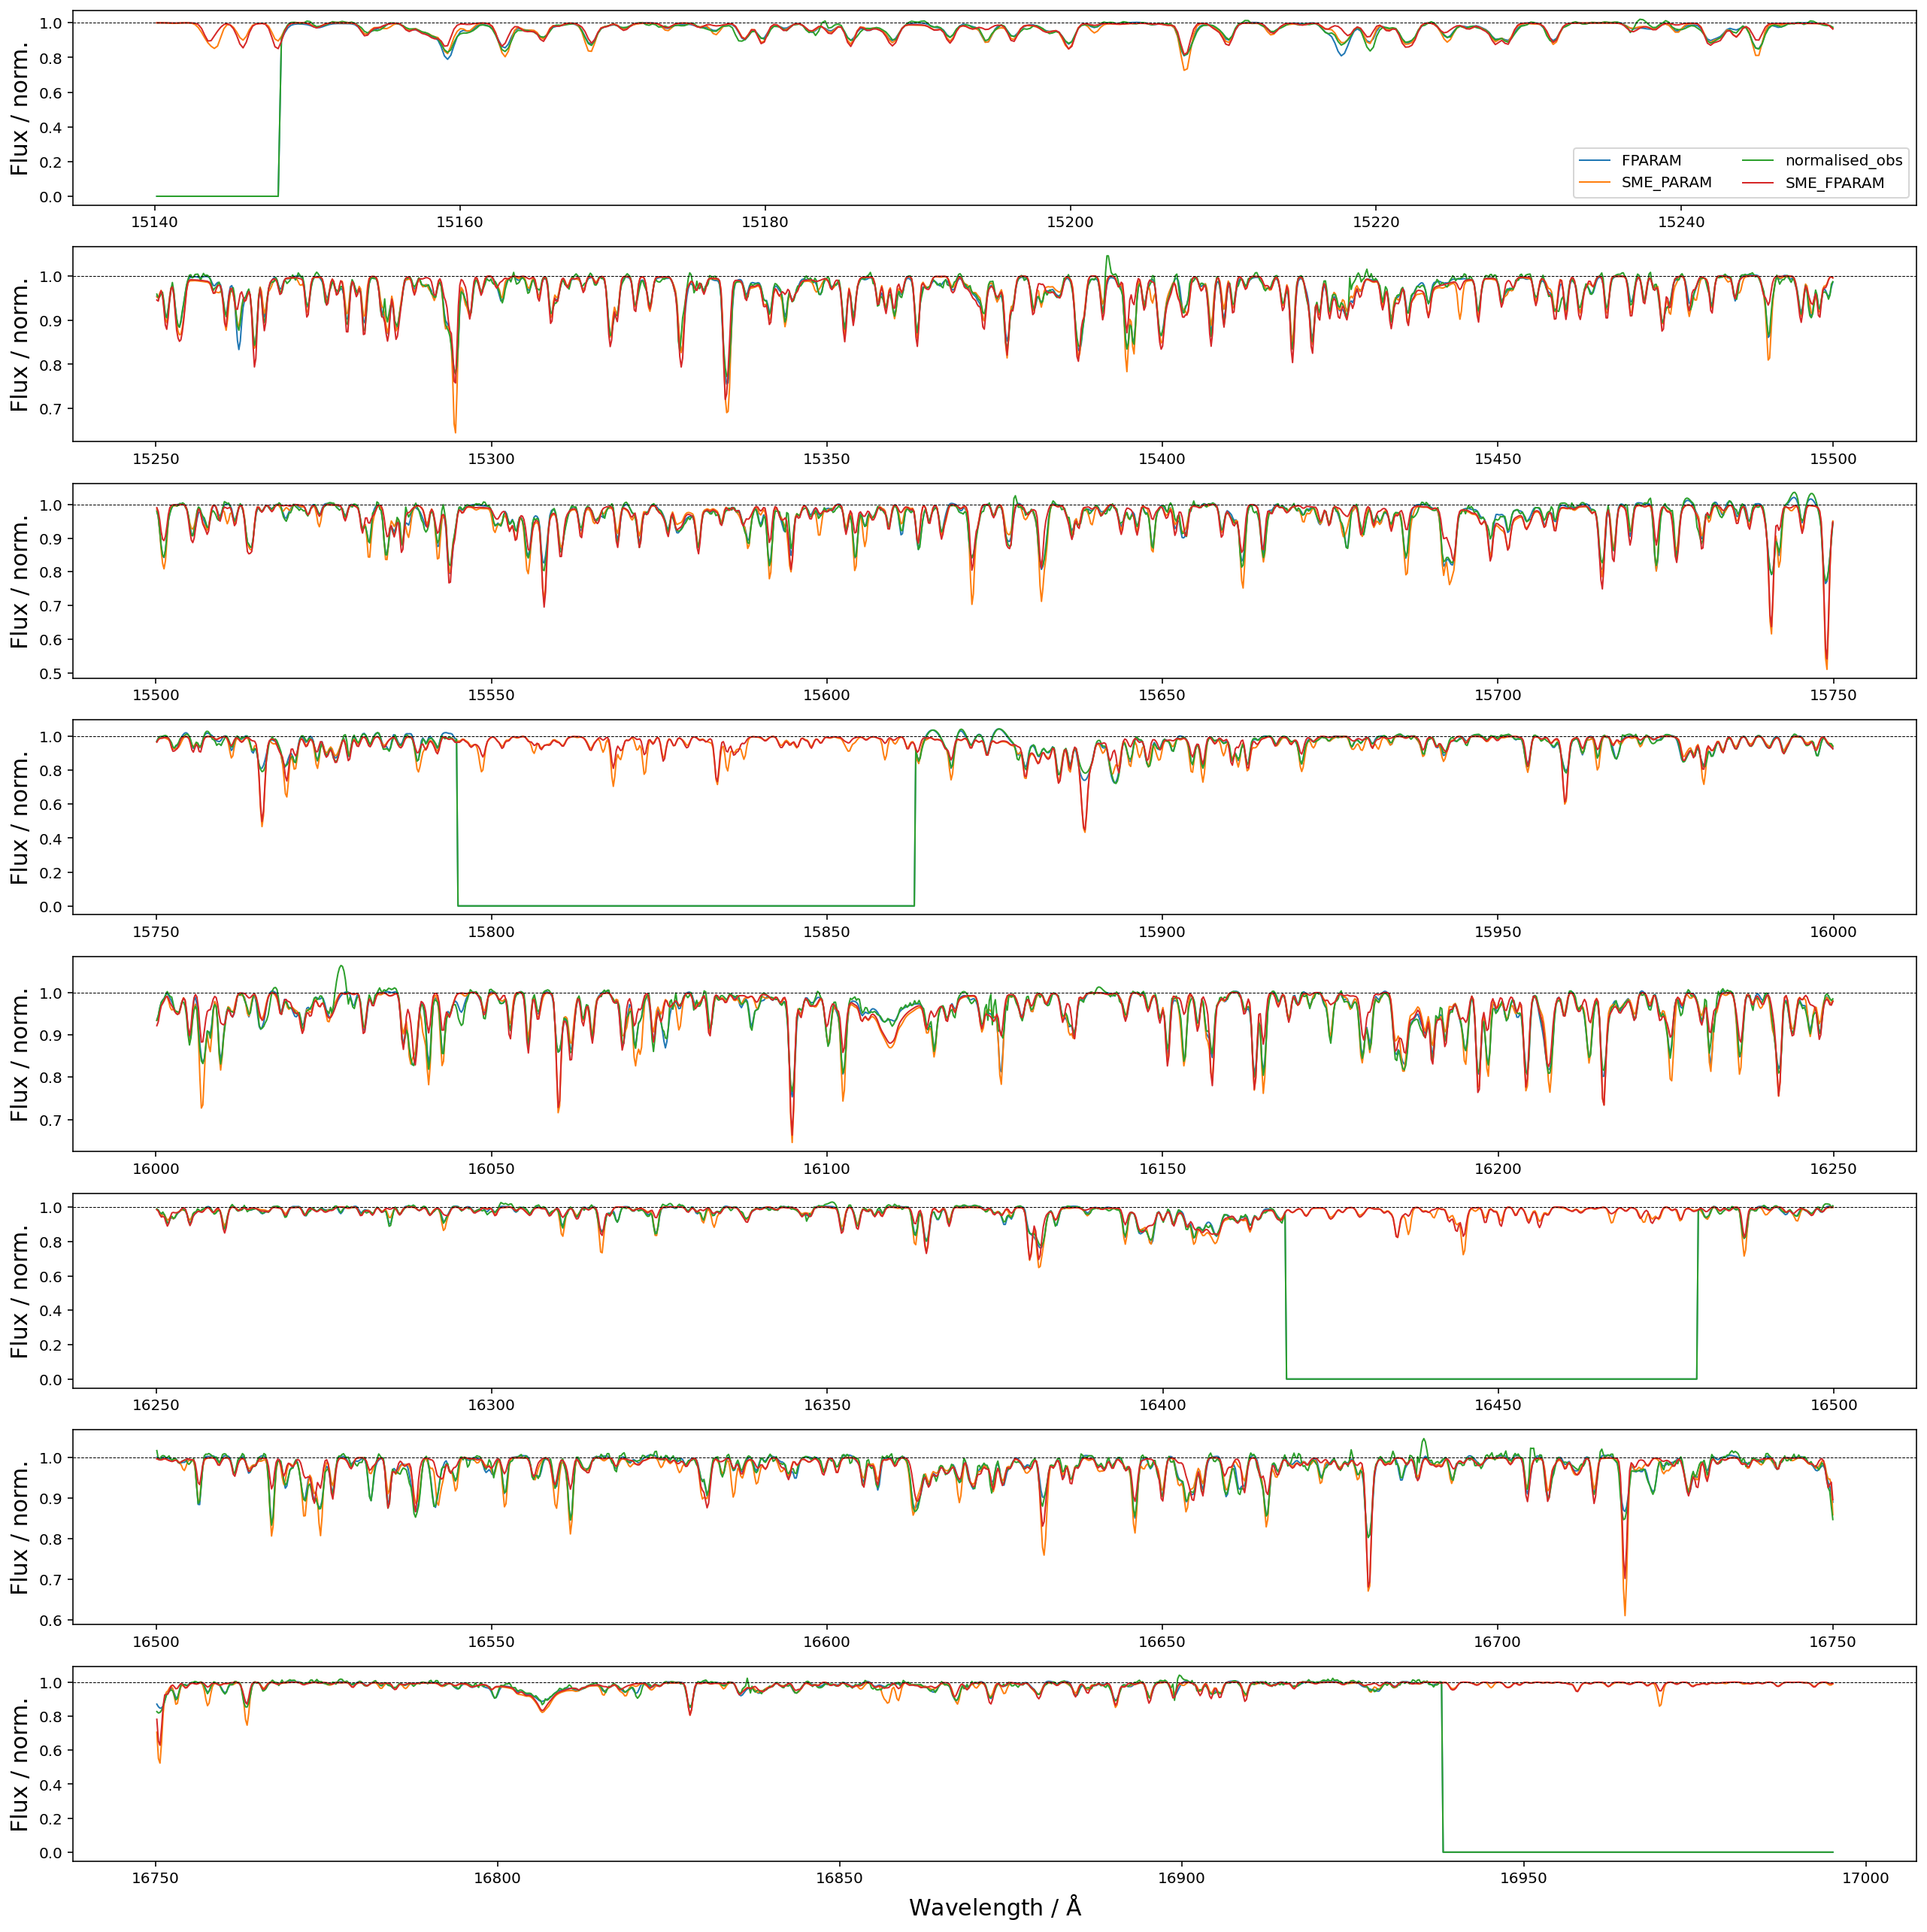

In [48]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (masked_spec['WAVE'] > spectral_range[0]) & (masked_spec['WAVE'] < spectral_range[1]) # spectra range for the observed spectra 
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1]) # spectra range for the synthetic spectra 
    
    
    ax = gs[panel_index]
    # line list 
    
#     selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
#     vline = linelist['Wavelength'][selec]
#     element = linelist['Element'][selec]
#     ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
#     for i in range(len(vline)):
#         if (i % 2) == 0:
#             ax.text(vline[i], 0.01, element[i])
#         else: 
#             ax.text(vline[i], -0.01, element[i])


    
#     ax.plot(
#         masked_spec['WAVE'][in_spectral_range],
#         masked_spec['SPEC'][in_spectral_range],
#         label = 'Observation', lw=1
#     )

    
    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        bestfit_renorm[in_spectral_range_s],
        label = 'FPARAM', lw=1
    )

    
    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        sme_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_PARAM', lw=1
    )

#     ax.plot(
#         LET_a['wave'][in_spectral_range_s],
#         LET_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
#         label = 'SME_LTE', lw=1
#     )
    
#     ax.plot(
#         sme_g['wave'][in_spectral_range_s],
#         sme_g['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
#         label = 'SME_GALAH', lw=1
#     )

#     ax.plot(
#         sme_h['wave'][in_spectral_range_s],
#         sme_h['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
#         label = 'SME_HAYES', lw=1
#     )
        
        
    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        flux_renorm[in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'normalised_obs', lw=1
    )
    
    ax.plot(
        uncali_a['wave'][in_spectral_range_s],
        uncali_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_FPARAM', lw=1
    )
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()
#plt.savefig('figures/uncalibrated_00202281-7201135.png')

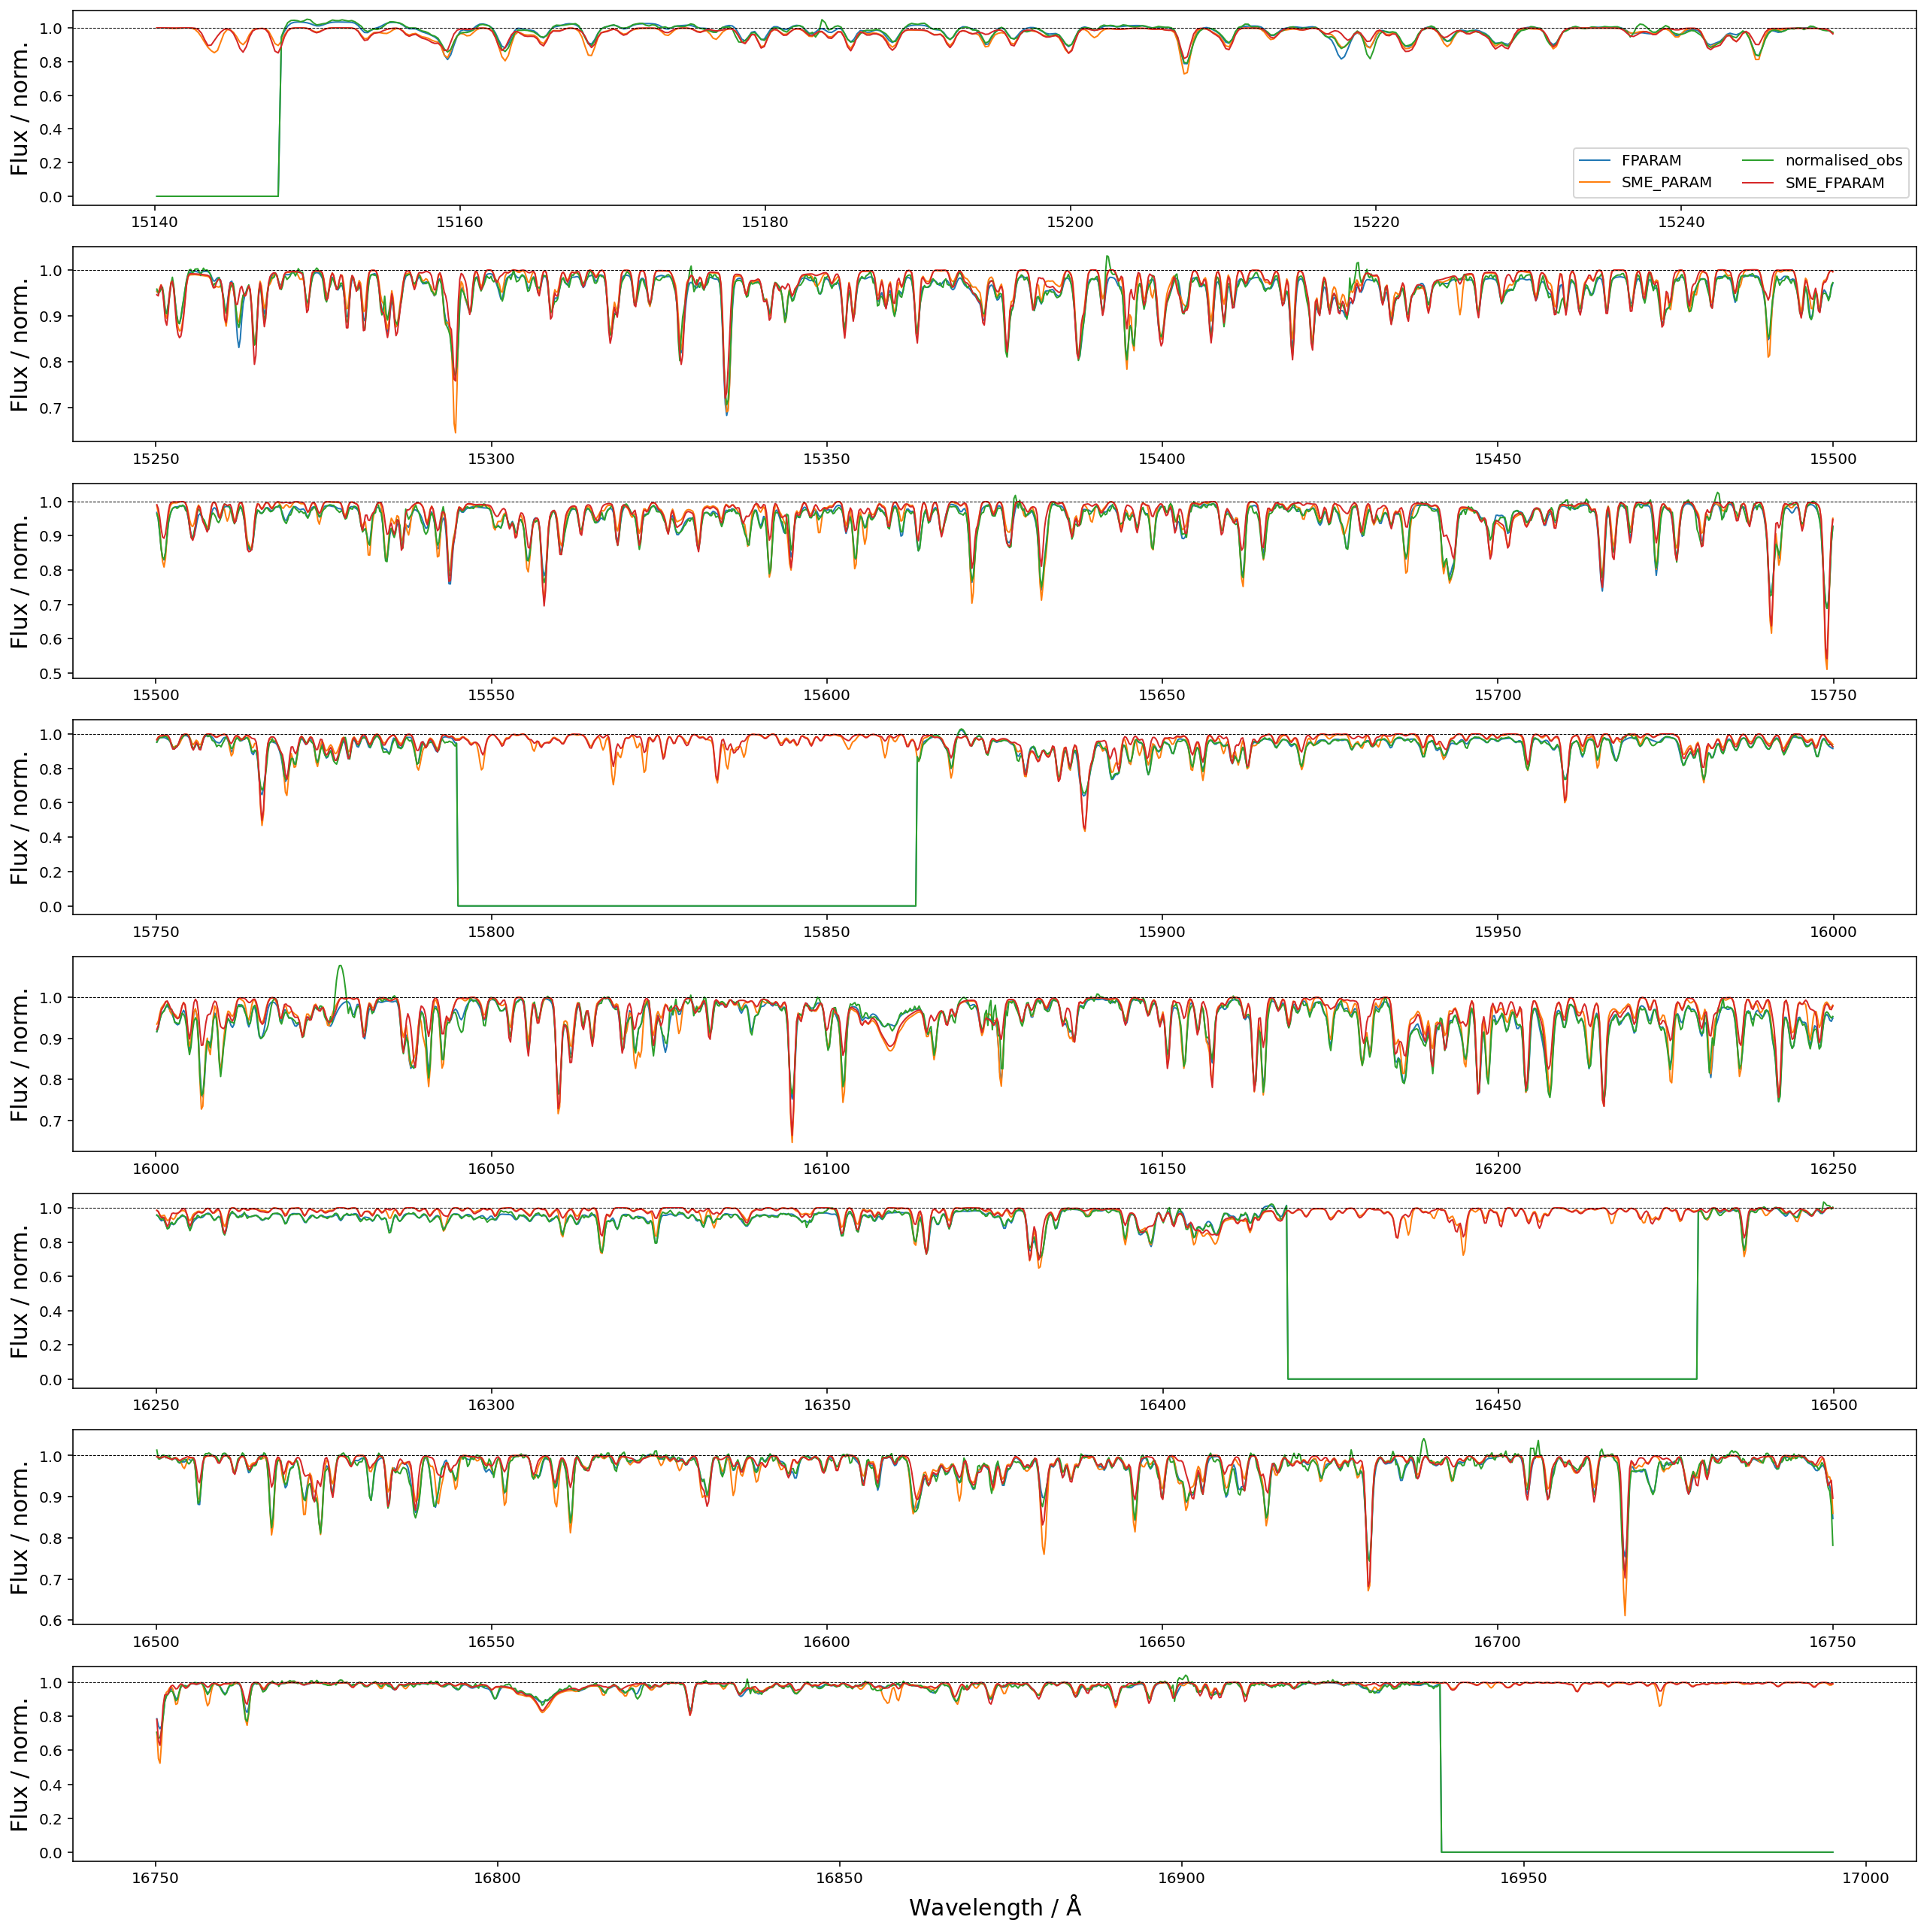

In [30]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (masked_spec['WAVE'] > spectral_range[0]) & (masked_spec['WAVE'] < spectral_range[1]) # spectra range for the observed spectra 
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1]) # spectra range for the synthetic spectra 
    
    
    ax = gs[panel_index]
    # line list 
    
#     selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
#     vline = linelist['Wavelength'][selec]
#     element = linelist['Element'][selec]
#     ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
#     for i in range(len(vline)):
#         if (i % 2) == 0:
#             ax.text(vline[i], 0.01, element[i])
#         else: 
#             ax.text(vline[i], -0.01, element[i])


    
#     ax.plot(
#         masked_spec['WAVE'][in_spectral_range],
#         masked_spec['SPEC'][in_spectral_range],
#         label = 'Observation', lw=1
#     )

    
    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        bestfit_renorm[in_spectral_range_s],
        label = 'FPARAM', lw=1
    )

    
    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        sme_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_PARAM', lw=1
    )

#     ax.plot(
#         LET_a['wave'][in_spectral_range_s],
#         LET_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
#         label = 'SME_LTE', lw=1
#     )
    
#     ax.plot(
#         sme_g['wave'][in_spectral_range_s],
#         sme_g['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
#         label = 'SME_GALAH', lw=1
#     )

#     ax.plot(
#         sme_h['wave'][in_spectral_range_s],
#         sme_h['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
#         label = 'SME_HAYES', lw=1
#     )
        
        
    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        flux_renorm[in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'normalised_obs', lw=1
    )
    
    ax.plot(
        uncali_a['wave'][in_spectral_range_s],
        uncali_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_FPARAM', lw=1
    )
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()
#plt.savefig('figures/uncalibrated_00202281-7201135.png')

## compute chi difference

In [17]:
chi_table = Table.read('chi_square_uncalibrated.csv',format='csv')

In [18]:
chi_table['chi_unca']= chi_table['chi_O_01']

In [19]:
chi_table['diff']= chi_table['chi_unca']-chi_table['chi_apogee']

In [20]:
agh = Table.read('agh_final.fits')
agh_chi = agh['tmass_id','FE_H_1','O_FE_1','TI_FE','TEFF_1','LOGG_1','fe_h','O_fe','Ti_fe','teff','logg']
apogee_chi = join(agh_chi,chi_table,keys='tmass_id')

Text(0.5, 1.0, 'APOGEE [Fe/H] vs [O/Fe] (uncalibrated)')

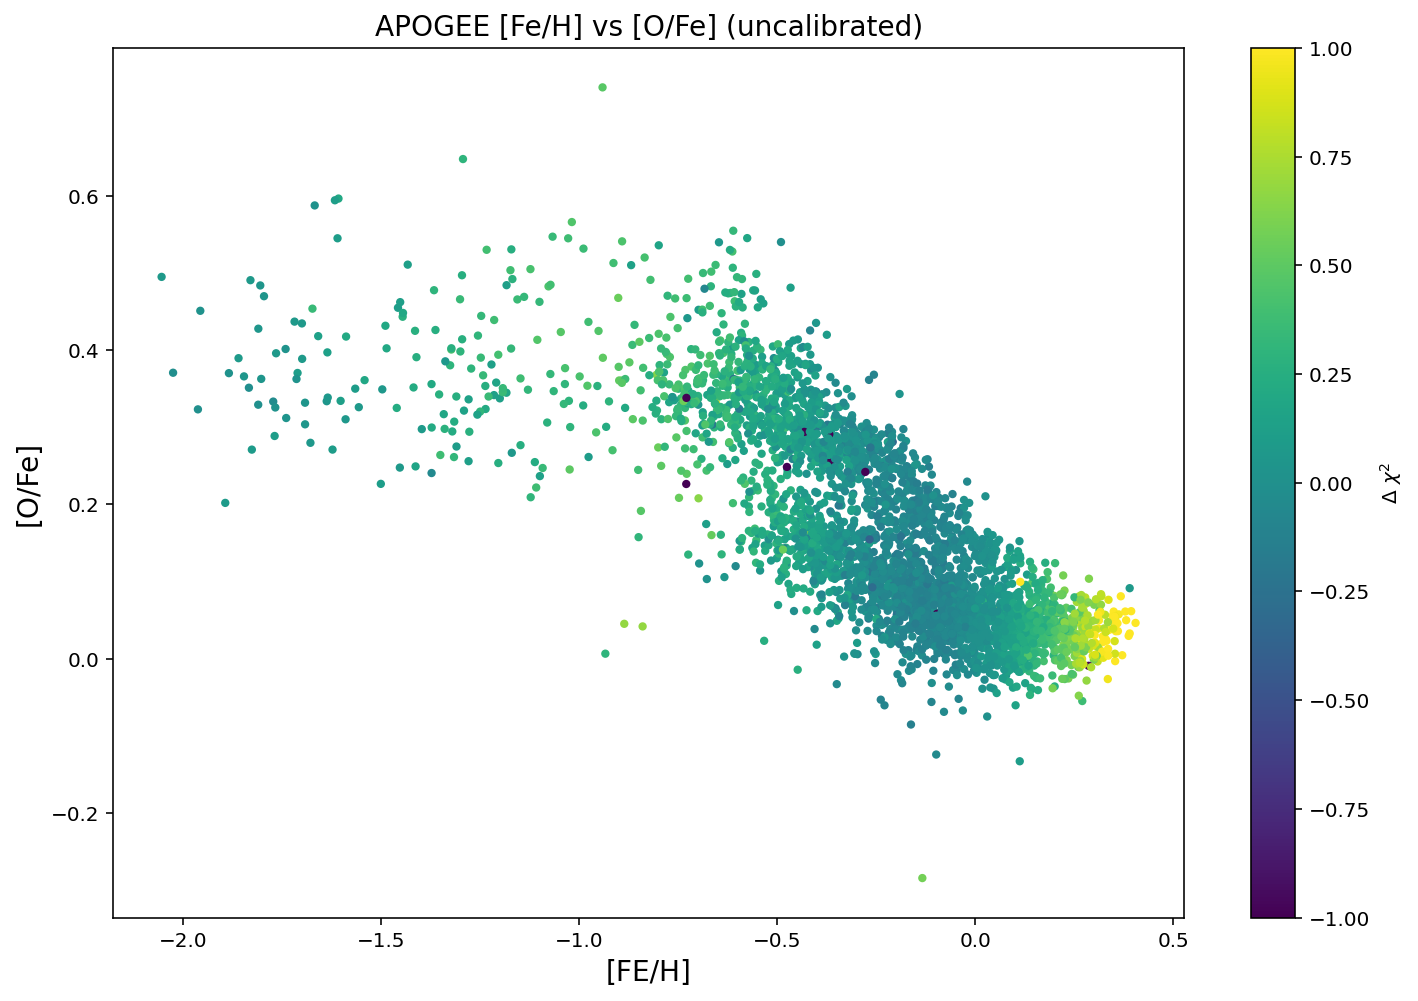

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(apogee_chi['FE_H_1'],apogee_chi['O_FE_1'],s=10,c=apogee_chi['diff'],vmin=-1,vmax=1)
plt.colorbar(label='$\Delta$ $\chi^2$')
plt.xlabel('[FE/H]',fontsize=14)
plt.ylabel('[O/Fe]',fontsize=14)
plt.title('APOGEE [Fe/H] vs [O/Fe] (uncalibrated)',fontsize=14)


In [42]:
teff = agh['FPARAM'][:,0]
logg = agh['FPARAM'][:,1]
vmic = 10**agh['FPARAM'][:,2]
fe_h = agh['FPARAM'][:,3]
a_fe = agh['FPARAM'][:,6]
vsini = 10**agh['FPARAM'][:,7]

FELEM: (C, CI, N, O, Na, Mg, Al, Si, P, S, K, Ca, Ti, TiII, V, Cr, Mn, Fe, Co, Ni, Cu, Ge, Rb, Ce, Nd, Yb, C13)


In [41]:
agh['FELEM']

0.0070815 .. 0.034111
0.16135 .. 0.20593
-0.016323 .. 0.16471
-0.0064976 .. 0.062037
-0.023063 .. 0.07909
0.075968 .. 0.27397
0.091493 .. 0.3972
0.099396 .. -0.030734
-0.0078657 .. 0.14077
...
0.046395 .. 0.30906


In [32]:
Table.read('agh_sme_input_final.fits')

tmass_id,teff,TEFF_galah,LOGG_galah,FE_H_galah,VMICRO_galah,TEFF_aspcap,LOGG_aspcap,FE_H_aspcap,VMICRO_aspcap,TEFF_hayes,LOGG_hayes,FE_H_hayes,VMICRO_hayes,SME_abund_aspcap [99],SME_abund_galah [99],SME_abund_hayes [99]
,K,K,log(cm.s**-2),,km / s,,,,,,,,,,,
bytes17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
00041790-7249588,4989.346,4989.346,3.438788,-0.15657997,1.1532416,4995.7305,3.3600206,-0.16684,1.0906038,4988.765,3.2571368,-0.15568,1.32855,0.9207329964112737 .. -20.035866292709752,0.9205625733014771 .. -20.035946685904197,0.9202381246022361 .. -20.03609977828553
00050927-5144526,4663.06,4663.06,2.4809353,0.047055244,1.2964934,4631.6763,2.3122554,0.042014,1.2626413,4631.6763,2.3122554,0.042014,1.32255,0.9204896108869519 .. -20.035981108800303,0.9204871620649826 .. -20.035982264175953,0.9203569082755311 .. -20.03604372348477
00063954-2027036,4805.0884,4805.0884,3.3792126,0.30552816,1.2236698,4803.6973,3.3598974,0.31924,0.3010163,4803.6973,3.3598974,0.31924,1.34564,0.9206945665870803 .. -20.035884419798673,0.9208969288277814 .. -20.035788975390883,0.9208130432910928 .. -20.035828537565465
00074341-2000506,4582.43,4582.43,2.3496225,-0.05088377,1.3450168,4642.8086,2.4252458,0.053541,1.3086092,4643.341,2.3563843,0.069331,1.31582,0.9206710477225984 .. -20.035895513861675,0.9204993099547375 .. -20.03597653272538,0.9206987100910142 .. -20.03588246529942
00081109-2105478,4849.1235,4849.1235,3.4563522,0.09749079,1.2043685,4823.158,3.3356752,0.14806,0.96628004,4823.158,3.3356752,0.14806,1.34197,0.9206963974220335 .. -20.03588355618901,0.9208234191179113 .. -20.03582364391308,0.9206642217551434 .. -20.035898733785878
00082727-5205478,4572.583,4572.583,2.6192114,-0.36827755,1.3512992,4612.0444,2.5620725,-0.26803,1.3157398,4612.0444,2.5620725,-0.26803,1.29671,0.920265641749686 .. -20.036086792117814,0.9195899197522363 .. -20.03640579797254,0.9203276580819956 .. -20.036057526173053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23535446+1626538,4787.6665,4787.6665,2.380546,-0.34010935,1.2317343,4816.457,2.4711182,-0.44812,1.3159215,4816.457,2.4711182,-0.44812,1.30376,0.9199960552883248 .. -20.03621403479595,0.9204768695757024 .. -20.03598712029614,0.9198193094604739 .. -20.036297477666842
